# New CVID data

All samples (batch 1 + batch 2)

14.12.2020

09.02.2021: reanalysis without twins

This is a preprocessing notebook, so this happens here:

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:

- load
- filter genes, cells, add info
- perform **step 1** of calling doublets using Krzysztof's bertie doublet caller:
    - see bertie_doublet_caller.ipynb in /home/jovyan/ and read comments
- concatenate
- add doublet scores from saved tables (bertie)
- filter MT-high cells
- make cells (obs) and var (genes) unique
- parsing souporcell deconvolution results
- save preprocessed object

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scrublet as scr
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [5]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [6]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

### Reading and preprocessing

In [7]:
# sample ID GEX + sample ID CITE (coupled)
samples = [
           # batch 1 samples
           '35008_CV005_RV9039258_and_35008_CV005_RV9039282',
           '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
           '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
           '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
           '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
           '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
           #'35008_CV005_RV9039264_and_35008_CV005_RV9039288',
           #'35008_CV005_RV9039265_and_35008_CV005_RV9039289',
          
          # batch 2 samples
          '35171_CV005_RV9039361', # CV005_RV9039361 + CV005_RV9039386, unstim
          '35171_CV005_RV9039362', # CV005_RV9039362 + CV005_RV9039387, CD40L
          '35171_CV005_RV9039363', # CV005_RV9039363 + CV005_RV9039388, CD3
          #'35171_CV005_RV9039364', # CV005_RV9039364 + CV005_RV9039389, BCR (a-IgM)
          ]


In [8]:
sample2activation = {}

sample2activation['35008_CV005_RV9039258_and_35008_CV005_RV9039282'] = 'unstim'
sample2activation['35008_CV005_RV9039259_and_35008_CV005_RV9039283'] = 'unstim'

sample2activation['35008_CV005_RV9039260_and_35008_CV005_RV9039284'] = 'CD40L'
sample2activation['35008_CV005_RV9039261_and_35008_CV005_RV9039285'] = 'CD40L'

sample2activation['35008_CV005_RV9039262_and_35008_CV005_RV9039286'] = 'CD3'
sample2activation['35008_CV005_RV9039263_and_35008_CV005_RV9039287'] = 'CD3'

#sample2activation['35008_CV005_RV9039264_and_35008_CV005_RV9039288'] = 'BCR' # TO EXCLUDE!!!
#sample2activation['35008_CV005_RV9039265_and_35008_CV005_RV9039289'] = 'BCR' # TO EXCLUDE!!!


sample2activation['35171_CV005_RV9039361'] = 'unstim'

sample2activation['35171_CV005_RV9039362'] = 'CD40L'

sample2activation['35171_CV005_RV9039363'] = 'CD3'

#sample2activation['35171_CV005_RV9039364'] = 'BCR' # TO EXCLUDE!!!


In [10]:
%%time

# reading data just to see how many cells cellranger called and also to add donor information

holder = []


for sample in samples:
    print('sample', sample,
          "from scRNA-seq samples", list(samples).index(sample)+1,
          'out of', len(samples))
    
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    
    
    path_complete = path+'filtered_feature_bc_matrix.h5'
    holder.append(sc.read_10x_h5(path_complete,
                                gex_only=False))
    
    holder[-1].var_names_make_unique()
    
    # Adding metadata
    
    curr_info = sample2activation[sample]
    
    holder[-1].obs['stimulation'] = curr_info
    holder[-1].layers['counts'] = holder[-1].X.copy()
    #print('this was tissue block', block, 'sample:', sample)
    
    # Sample information
    holder[-1].obs['sample'] = sample
    # In cell_id we save barcode+sample index, to be unique in the future
    holder[-1].obs['cell_id'] = [i+'_'+j for i,j in zip(holder[-1].obs.index, holder[-1].obs['sample'])]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    holder[-1].obs['dataset'] = 'GEX+CITE-seq'
    holder[-1].obs['technique'] = '10X'


adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282 from scRNA-seq samples 1 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039258_and_35008_CV005_RV9039282_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
sample 35008_CV005_RV9039259_and_35008_CV005_RV9039283 from scRNA-seq samples 2 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039259_and_35008_CV005_RV9039283_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
sample 35008_CV005_RV9039260_and_35008_CV005_RV9039284 from scRNA-seq samples 3 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039260_and_35008_CV005_RV9039284_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
sample 35008_CV005_RV9039261_and_35008_CV005_RV9039285 from scRNA-seq samples 4 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039261_and_35008_CV005_RV9039285_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
sample 35008_CV005_RV9039262_and_35008_CV005_RV9039286 from scRNA-seq samples 5 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039262_and_35008_CV005_RV9039286_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
sample 35008_CV005_RV9039263_and_35008_CV005_RV9039287 from scRNA-seq samples 6 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039263_and_35008_CV005_RV9039287_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
sample 35171_CV005_RV9039361 from scRNA-seq samples 7 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039361_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)
sample 35171_CV005_RV9039362 from scRNA-seq samples 8 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039362_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:05)
sample 35171_CV005_RV9039363 from scRNA-seq samples 9 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35171_CV005_RV9039363_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:06)


layers concatenation is not yet available for 'outer' intersection and will be ignored.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


CPU times: user 6min 24s, sys: 58.8 s, total: 7min 23s
Wall time: 7min 22s


In [34]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Adding donor information

## Adding souporcell results

In [35]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
        '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
        '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
        '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
        '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
        '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
        '35171_CV005_RV9039361', '35171_CV005_RV9039362',
        '35171_CV005_RV9039363'], dtype=object),
 array([17720, 19435, 12415, 19832, 22268, 20522, 21465, 23553, 29947]))

In [36]:
souporcell_dirs = {}

prefix = '/lustre/scratch117/cellgen/team292/aa22/souporcell_analyses/souporcell_scRNA-seq_CVID_revisions_202009/'

souporcell_dirs['35008_CV005_RV9039258_and_35008_CV005_RV9039282'] = prefix + 'souporcell_result_35008_CV005_RV9039258_and_35008_CV005_RV9039282_20200918/'
souporcell_dirs['35008_CV005_RV9039259_and_35008_CV005_RV9039283'] = prefix + 'souporcell_result_35008_CV005_RV9039259_and_35008_CV005_RV9039283_20200919/'
souporcell_dirs['35008_CV005_RV9039260_and_35008_CV005_RV9039284'] = prefix + 'souporcell_result_35008_CV005_RV9039260_and_35008_CV005_RV9039284_20200918/'
souporcell_dirs['35008_CV005_RV9039261_and_35008_CV005_RV9039285'] = prefix + 'souporcell_result_35008_CV005_RV9039261_and_35008_CV005_RV9039285_20200918/'
souporcell_dirs['35008_CV005_RV9039262_and_35008_CV005_RV9039286'] = prefix + 'souporcell_result_35008_CV005_RV9039262_and_35008_CV005_RV9039286_20200919/'
souporcell_dirs['35008_CV005_RV9039263_and_35008_CV005_RV9039287'] = prefix + 'souporcell_result_35008_CV005_RV9039263_and_35008_CV005_RV9039287_20200919/'
#souporcell_dirs['35008_CV005_RV9039264_and_35008_CV005_RV9039288'] = prefix + 'souporcell_result_35008_CV005_RV9039264_and_35008_CV005_RV9039288_20200918/'
#souporcell_dirs['35008_CV005_RV9039265_and_35008_CV005_RV9039289'] = prefix + 'souporcell_result_35008_CV005_RV9039265_and_35008_CV005_RV9039289_20200919/'

souporcell_dirs['35171_CV005_RV9039361'] = prefix + 'souporcell_result_35171_CV005_RV9039361_20201214/'
souporcell_dirs['35171_CV005_RV9039362'] = prefix + 'souporcell_result_35171_CV005_RV9039362_20201214/'
souporcell_dirs['35171_CV005_RV9039363'] = prefix + 'souporcell_result_35171_CV005_RV9039363_20201214/'
#souporcell_dirs['35171_CV005_RV9039364'] = prefix + 'souporcell_result_35171_CV005_RV9039364_20201214/'




In [37]:
holder = []

for sample in list(souporcell_dirs.keys()):
    print('sample ', sample)
    curr_table = pd.read_csv(souporcell_dirs[sample]+'clusters.tsv', sep='\t', index_col=0)
    curr_table['barcode_sample'] = [i+'_'+sample for i in curr_table.index]
    print('len of curr table is', len(curr_table))
    holder.append(curr_table)
    

sample  35008_CV005_RV9039258_and_35008_CV005_RV9039282
len of curr table is 17720
sample  35008_CV005_RV9039259_and_35008_CV005_RV9039283
len of curr table is 19435
sample  35008_CV005_RV9039260_and_35008_CV005_RV9039284
len of curr table is 12415
sample  35008_CV005_RV9039261_and_35008_CV005_RV9039285
len of curr table is 19832
sample  35008_CV005_RV9039262_and_35008_CV005_RV9039286
len of curr table is 22268
sample  35008_CV005_RV9039263_and_35008_CV005_RV9039287
len of curr table is 20522
sample  35171_CV005_RV9039361
len of curr table is 21465
sample  35171_CV005_RV9039362
len of curr table is 23553
sample  35171_CV005_RV9039363
len of curr table is 29947


In [38]:
souporcell_meta_table = pd.concat(holder,join='outer')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [39]:
souporcell_meta_table

,assignment,barcode_sample,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,log_prob_doublet,log_prob_singleton,status
barcode,,,,,,,,,,,,,
AAACCTGAGAATGTGT-1,2,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,-2236.986538,-2008.046376,-475.424455,-1941.943752,-2068.178314,-2225.106343,NaN,NaN,-676.368720,-475.424455,singlet
AAACCTGAGACTAAGT-1,5,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,-3425.356285,-3642.580885,-3139.984848,-3138.138289,-2929.540069,-583.134595,NaN,NaN,-1064.970129,-583.134595,singlet
AAACCTGAGATCCCGC-1,0/5,AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...,-141.919309,-203.526003,-181.691712,-162.848398,-155.644318,-164.511791,NaN,NaN,-110.554232,-141.919309,doublet
AAACCTGAGCCGCCTA-1,2,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,-307.347688,-325.516654,-81.076857,-301.741254,-272.284983,-356.998605,NaN,NaN,-113.731431,-81.076857,singlet
AAACCTGAGCGCCTCA-1,0,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,-90.977753,-346.190370,-336.979961,-307.415381,-267.327526,-291.146090,NaN,NaN,-109.375279,-90.977753,singlet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGGGAGTA-1,3/0,TTTGTCATCGGGAGTA-1_35171_CV005_RV9039363,-744.946211,-1618.021327,-1479.478656,-640.033993,-1481.340187,-1435.902737,-1392.534132,-1390.397574,-607.658373,-640.033993,doublet
TTTGTCATCTACTATC-1,6/7,TTTGTCATCTACTATC-1_35171_CV005_RV9039363,-2356.467788,-3680.968244,-4007.516475,-4539.666228,-4643.440553,-4293.027153,-2968.792484,-3119.504881,-1904.330027,-2356.467788,doublet
TTTGTCATCTCGGACG-1,6/0,TTTGTCATCTCGGACG-1_35171_CV005_RV9039363,-395.579505,-650.546470,-598.801169,-733.933873,-633.298213,-612.040005,-371.766439,-668.838812,-342.719165,-371.766439,doublet


In [40]:
souporcell_meta_table.set_index('barcode_sample', inplace=True, drop=False)

In [41]:
souporcell_meta_table.index

Index(['AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCTACCGC-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCTGTTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGCTAGCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGCTCTTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       ...
       'TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363',
       'TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363',
       'TTTGTCATCCTTGACC-1_35171_CV005_RV9039363',
       'TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363',
       'TTTGTCA

In [42]:
adata.obs

,batch,cell_id,dataset,n_counts,percent_mito,sample,stimulation,technique,barcode
AAACCTGAGAATGTGT-1,0,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,7290.0,0.018107,35008_CV005_RV9039258_and_35008_CV005_RV9039282,unstim,10X,AAACCTGAGAATGTGT-1
AAACCTGAGACTAAGT-1,0,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,12744.0,0.039077,35008_CV005_RV9039258_and_35008_CV005_RV9039282,unstim,10X,AAACCTGAGACTAAGT-1
AAACCTGAGATCCCGC-1,0,AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,801.0,0.031211,35008_CV005_RV9039258_and_35008_CV005_RV9039282,unstim,10X,AAACCTGAGATCCCGC-1
AAACCTGAGCCGCCTA-1,0,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1275.0,0.039216,35008_CV005_RV9039258_and_35008_CV005_RV9039282,unstim,10X,AAACCTGAGCCGCCTA-1
AAACCTGAGCGCCTCA-1,0,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1137.0,0.028144,35008_CV005_RV9039258_and_35008_CV005_RV9039282,unstim,10X,AAACCTGAGCGCCTCA-1
...,...,...,...,...,...,...,...,...,...
TTTGTCATCGGGAGTA-1-1,8,TTTGTCATCGGGAGTA-1_35171_CV005_RV9039363,GEX+CITE-seq,10751.0,0.006697,35171_CV005_RV9039363,CD3,10X,TTTGTCATCGGGAGTA-1
TTTGTCATCTACTATC-1,8,TTTGTCATCTACTATC-1_35171_CV005_RV9039363,GEX+CITE-seq,22685.0,0.040026,35171_CV005_RV9039363,CD3,10X,TTTGTCATCTACTATC-1
TTTGTCATCTCGGACG-1,8,TTTGTCATCTCGGACG-1_35171_CV005_RV9039363,GEX+CITE-seq,3749.0,0.010936,35171_CV005_RV9039363,CD3,10X,TTTGTCATCTCGGACG-1
TTTGTCATCTTGGGTA-1,8,TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363,GEX+CITE-seq,3320.0,0.038855,35171_CV005_RV9039363,CD3,10X,TTTGTCATCTTGGGTA-1


In [43]:
adata.obs['cell_id']

AAACCTGAGAATGTGT-1      AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...
AAACCTGAGACTAAGT-1      AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...
AAACCTGAGATCCCGC-1      AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...
AAACCTGAGCCGCCTA-1      AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...
AAACCTGAGCGCCTCA-1      AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...
                                              ...                        
TTTGTCATCGGGAGTA-1-1             TTTGTCATCGGGAGTA-1_35171_CV005_RV9039363
TTTGTCATCTACTATC-1               TTTGTCATCTACTATC-1_35171_CV005_RV9039363
TTTGTCATCTCGGACG-1               TTTGTCATCTCGGACG-1_35171_CV005_RV9039363
TTTGTCATCTTGGGTA-1               TTTGTCATCTTGGGTA-1_35171_CV005_RV9039363
TTTGTCATCTTTCCTC-1               TTTGTCATCTTTCCTC-1_35171_CV005_RV9039363
Name: cell_id, Length: 187157, dtype: object

In [44]:
len(set(adata.obs['cell_id']) & set(souporcell_meta_table.index))

187157

In [45]:
adata

AnnData object with n_obs × n_vars = 187157 × 33886 
    obs: 'batch', 'cell_id', 'dataset', 'n_counts', 'percent_mito', 'sample', 'stimulation', 'technique', 'barcode'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'gene_ids-8', 'feature_types-8', 'genome-8'

In [46]:
souporcell_meta_table.index

Index(['AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCTACCGC-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGCTGTTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGCTAGCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       'AAACCTGAGGCTCTTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       ...
       'TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363',
       'TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363',
       'TTTGTCATCCTTGACC-1_35171_CV005_RV9039363',
       'TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363',
       'TTTGTCA

In [51]:
def add_souporcell(adata_obj, barcode):
    
    # cell_id column here is barcode_sample column (unique IDs)
    curr_barcode_sample = adata_obj.obs.loc[barcode,'cell_id']
    curr_sample = adata_obj.obs.loc[barcode,'sample']
    
    #print('curr_barcode_sample:', curr_barcode_sample)

    if curr_barcode_sample in souporcell_meta_table.index:
        assignment = curr_sample+'_'+souporcell_meta_table.loc[curr_barcode_sample,'assignment']
        return(assignment)
    else:
        return('no_deconv_yet')

In [53]:
adata.obs['barcode'] = adata.obs.index

In [54]:
adata.obs['souporcell_assignment'] = adata.obs['barcode'].apply(lambda x: add_souporcell(adata,x))

In [55]:
np.unique(adata.obs['souporcell_assignment'], return_counts=True)

(array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282_0',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_0/1',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_0/2',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_0/3',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_0/4',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_0/5',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1/0',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1/2',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1/3',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1/4',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1/5',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_2',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_2/0',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_2/1',
        '35008_CV005_RV9039258_and_35008_CV005_RV9039282_2/3'

In [56]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363'], dtype=object)

In [57]:
# flagging inter-individual doublets
adata.obs['inter_ind_doublet'] = [1 if '/' in elem else 0 for elem in adata.obs['souporcell_assignment']]


In [58]:
# checking if it all adds up
np.unique(adata.obs['inter_ind_doublet'], return_counts=True)

(array([0, 1]), array([122228,  64929]))

In [59]:
adata

AnnData object with n_obs × n_vars = 187157 × 33886 
    obs: 'batch', 'cell_id', 'dataset', 'n_counts', 'percent_mito', 'sample', 'stimulation', 'technique', 'barcode', 'souporcell_assignment', 'inter_ind_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'gene_ids-8', 'feature_types-8', 'genome-8'

In [60]:
# so about 35% doubets (inter-individual)
64929 / 187157


0.34692263714421584

In [61]:
# discarding inter-individual doublets
adata = adata[adata.obs['inter_ind_doublet'] == 0].copy()

In [62]:
adata

AnnData object with n_obs × n_vars = 122228 × 33886 
    obs: 'batch', 'cell_id', 'dataset', 'n_counts', 'percent_mito', 'sample', 'stimulation', 'technique', 'barcode', 'souporcell_assignment', 'inter_ind_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'gene_ids-8', 'feature_types-8', 'genome-8'

## Coming to temporary donor IDs matched across all samples

In [64]:
np.unique(adata.obs['souporcell_assignment'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282_0',
       '35008_CV005_RV9039258_and_35008_CV005_RV9039282_1',
       '35008_CV005_RV9039258_and_35008_CV005_RV9039282_2',
       '35008_CV005_RV9039258_and_35008_CV005_RV9039282_3',
       '35008_CV005_RV9039258_and_35008_CV005_RV9039282_4',
       '35008_CV005_RV9039258_and_35008_CV005_RV9039282_5',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_2',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_3',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_4',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283_5',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284_2',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284_3',
       '35008_CV005_RV9039260_and_35008_

In [65]:
def annot_temp_donor_ID(adata_obj, barcode):
    
    curr_souporcell_assignment = adata_obj.obs.loc[barcode, 'souporcell_assignment']
    
    if curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_0',
                                      '35008_CV005_RV9039260_and_35008_CV005_RV9039284_3',
                                      '35008_CV005_RV9039262_and_35008_CV005_RV9039286_0',
                                      '35008_CV005_RV9039265_and_35008_CV005_RV9039289_0']:
        return('1')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_1',
                                        '35008_CV005_RV9039260_and_35008_CV005_RV9039284_1',
                                        '35008_CV005_RV9039262_and_35008_CV005_RV9039286_2',
                                        '35008_CV005_RV9039264_and_35008_CV005_RV9039288_0']:
        return('2')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_2',
                                        '35008_CV005_RV9039260_and_35008_CV005_RV9039284_2',
                                        '35008_CV005_RV9039262_and_35008_CV005_RV9039286_4',
                                        '35008_CV005_RV9039265_and_35008_CV005_RV9039289_2']:
        return('3')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_3',
                                        '35008_CV005_RV9039260_and_35008_CV005_RV9039284_0',
                                        '35008_CV005_RV9039262_and_35008_CV005_RV9039286_3',
                                        '35008_CV005_RV9039264_and_35008_CV005_RV9039288_4']:
        return('4')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_4',
                                        '35008_CV005_RV9039260_and_35008_CV005_RV9039284_5',
                                        '35008_CV005_RV9039262_and_35008_CV005_RV9039286_5',
                                        '35008_CV005_RV9039265_and_35008_CV005_RV9039289_1']:
        return('5')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039258_and_35008_CV005_RV9039282_5',
                                        '35008_CV005_RV9039260_and_35008_CV005_RV9039284_4',
                                        '35008_CV005_RV9039262_and_35008_CV005_RV9039286_1',
                                        ]:
        return('6')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_0',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_5',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_5',
                                        '35008_CV005_RV9039264_and_35008_CV005_RV9039288_1']:
        return('7')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_1',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_2',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_0',
                                        '35008_CV005_RV9039264_and_35008_CV005_RV9039288_5']:
        return('8')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_2',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_3',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_2',
                                        '35008_CV005_RV9039265_and_35008_CV005_RV9039289_4']:
        return('9')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_3',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_0',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_3',
                                        '35008_CV005_RV9039265_and_35008_CV005_RV9039289_5']:
        return('10')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_4',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_1',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_4',
                                        '35008_CV005_RV9039265_and_35008_CV005_RV9039289_3']:
        return('11')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039259_and_35008_CV005_RV9039283_5',
                                        '35008_CV005_RV9039261_and_35008_CV005_RV9039285_4',
                                        '35008_CV005_RV9039263_and_35008_CV005_RV9039287_1',
                                        '35008_CV005_RV9039264_and_35008_CV005_RV9039288_3']:
        return('12')
    
    elif curr_souporcell_assignment in ['35008_CV005_RV9039264_and_35008_CV005_RV9039288_2']:
        return('13')
    
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_0',
                                       '35171_CV005_RV9039362_2',
                                       '35171_CV005_RV9039363_6',
                                       '35171_CV005_RV9039364_3']:
        return('14')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_1',
                                       '35171_CV005_RV9039362_7',
                                       '35171_CV005_RV9039363_4',
                                       '35171_CV005_RV9039364_0']:
        return('15')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_2',
                                       '35171_CV005_RV9039362_3',
                                       '35171_CV005_RV9039363_7',
                                       '35171_CV005_RV9039364_1']:
        return('16')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_3',
                                       '35171_CV005_RV9039362_1',
                                       '35171_CV005_RV9039363_2',
                                       '35171_CV005_RV9039364_7']:
        return('17')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_4',
                                       '35171_CV005_RV9039362_4',
                                       '35171_CV005_RV9039363_1',
                                       '35171_CV005_RV9039364_5']:
        return('18')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_5',
                                       '35171_CV005_RV9039362_5',
                                       '35171_CV005_RV9039363_5',
                                       '35171_CV005_RV9039364_4']:
        return('19')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_6',
                                       '35171_CV005_RV9039362_0',
                                       '35171_CV005_RV9039363_3',
                                       '35171_CV005_RV9039364_2']:
        return('20')
    elif curr_souporcell_assignment in ['35171_CV005_RV9039361_7',
                                       '35171_CV005_RV9039362_6',
                                       '35171_CV005_RV9039363_0',
                                       '35171_CV005_RV9039364_6']:
        return('21')
    
    else:
        #print('in exception, curr_souporcell_assignment is', curr_souporcell_assignment)
        return('not_assigned')
    

    

In [66]:
adata.obs['donor_ID_temp'] = adata.obs['barcode'].apply(lambda x: annot_temp_donor_ID(adata, x))

In [68]:
np.unique(adata.obs['donor_ID_temp'], return_counts=True)

(array(['1', '10', '11', '12', '14', '15', '16', '17', '18', '19', '2',
        '20', '21', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([ 6093,  5221,  6135,  5447,  5659,  5365,  5554,  5699,  6206,
         5264,  5391,  7113, 11247,  7514,  4576,  6336,  4883,  6867,
         6623,  5035]))

### here there is no donor 13 (temp ID) because it was only present in BCR sample (35008_CV005_RV9039264_and_35008_CV005_RV9039288)

So it was previously 21 donors, wihtout BCR activation it's now 20, without twins will be 18

# Going from temporary donor IDs to actual donor labels

# Adding final donor IDs from souporcell + deconvoluted values (by Eduardo from VCFs)

In [69]:
adata.obs['barcode']

AAACCTGAGAATGTGT-1        AAACCTGAGAATGTGT-1
AAACCTGAGACTAAGT-1        AAACCTGAGACTAAGT-1
AAACCTGAGCCGCCTA-1        AAACCTGAGCCGCCTA-1
AAACCTGAGCGCCTCA-1        AAACCTGAGCGCCTCA-1
AAACCTGAGGATGTAT-1        AAACCTGAGGATGTAT-1
                                ...         
TTTGTCATCCCTTGCA-1-1    TTTGTCATCCCTTGCA-1-1
TTTGTCATCCGCGTTT-1        TTTGTCATCCGCGTTT-1
TTTGTCATCGGAGGTA-1        TTTGTCATCGGAGGTA-1
TTTGTCATCGGCTACG-1-1    TTTGTCATCGGCTACG-1-1
TTTGTCATCTTGGGTA-1        TTTGTCATCTTGGGTA-1
Name: barcode, Length: 122228, dtype: object

In [70]:
def add_final_donor_labels(adata_obj, barcode):
    
    curr_temp_donor_ID = adata_obj.obs.loc[barcode, 'donor_ID_temp']
    
    if curr_temp_donor_ID == '1':
        return('CVID33')
    elif curr_temp_donor_ID == '2':
        return('CVID34')
    elif curr_temp_donor_ID == '3':
        return('CVID3')
    elif curr_temp_donor_ID == '4':
        return('CONTROL_twin')
    elif curr_temp_donor_ID == '5':
        return('CONTROL6')
    elif curr_temp_donor_ID == '6':
        return('CONTROL4')
    elif curr_temp_donor_ID == '7':
        return('CVID18')
    elif curr_temp_donor_ID == '8':
        return('CVID29')
    elif curr_temp_donor_ID == '9':
        return('CVID_twin')
    elif curr_temp_donor_ID == '10':
        return('CONTROL3')
    elif curr_temp_donor_ID == '11':
        return('CONTROL5')
    elif curr_temp_donor_ID == '12':
        return('CONTROL2')
    elif curr_temp_donor_ID == '13':
        return('CONTROL1')
    elif curr_temp_donor_ID == '14':
        return('CVID1')
    elif curr_temp_donor_ID == '15':
        return('CONTROL9')
    elif curr_temp_donor_ID == '16':
        return('CONTROL7')
    elif curr_temp_donor_ID == '17':
        return('CVID36')
    elif curr_temp_donor_ID == '18':
        return('CVID37')
    elif curr_temp_donor_ID == '19':
        return('CONTROL8')
    elif curr_temp_donor_ID == '20':
        return('CVID23')
    elif curr_temp_donor_ID == '21':
        return('CVID25')
    
    else:
        return('none')

In [71]:
adata.obs['donor'] = adata.obs['barcode'].apply(lambda x: add_final_donor_labels(adata, x))

In [72]:
np.unique(adata.obs['donor'])

array(['CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5', 'CONTROL6',
       'CONTROL7', 'CONTROL8', 'CONTROL9', 'CONTROL_twin', 'CVID1',
       'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37', 'CVID_twin'], dtype=object)

In [74]:
len(np.unique(adata.obs['donor']))

20

In [75]:
# discarting cells that are from twins
adata = adata[adata.obs['donor'].isin(['CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5', 'CONTROL6',
       'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1',
       'CVID18', 'CVID23', 'CVID25', 'CVID29', 'CVID3', 'CVID33',
       'CVID34', 'CVID36', 'CVID37'])].copy()

In [76]:
adata

AnnData object with n_obs × n_vars = 112617 × 33886 
    obs: 'batch', 'cell_id', 'dataset', 'n_counts', 'percent_mito', 'sample', 'stimulation', 'technique', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor_ID_temp', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'gene_ids-8', 'feature_types-8', 'genome-8'

In [80]:
adata.obs.loc[:,['cell_id','donor']]

,cell_id,donor
AAACCTGAGAATGTGT-1,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,CVID3
AAACCTGAGACTAAGT-1,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,CONTROL4
AAACCTGAGCCGCCTA-1,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,CVID3
AAACCTGAGCGCCTCA-1,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,CVID33
AAACCTGAGGATGTAT-1,AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_3...,CVID3
...,...,...
TTTGTCATCCCTTGCA-1-1,TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCCGCGTTT-1,TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363,CVID23
TTTGTCATCGGAGGTA-1,TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCGGCTACG-1-1,TTTGTCATCGGCTACG-1_35171_CV005_RV9039363,CVID25


In [79]:
# from here we need cells that we are takiing and their donor assignment
adata.obs.loc[:,['cell_id','donor']].to_csv(save_path + 'meta_cells_for_reanalysis_without_twins_without_BCR_activation_without_souporcell_doublets.csv')

# QC, cutoff decisions and reading again

In [81]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)  

In [82]:
# median of dtected genes
np.median(adata.obs['n_genes'])

1446.0

... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'stimulation' as categorical
... storing 'technique' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'donor_ID_temp' as categorical
... storing 'donor' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'feature_types-2' as categorical
... storing 'genome-2' as categorical
... storing 'feature_types-3' as categorical
... storing 'genome-3' as categorical
... storing 'feature_types-4' as categorical
... storing 'genome-4' as categorical
... storing 'feature_types-5' as categorical
... storing 'genome-5' as categorical
... storing 'feature_types-6' as categorical
... storing 'genome-6' as categorical
... storing 'feature_types-7' as categorical
... storing 'genome-7' as categorical
... storing 'feature_types-8' as categorical
... stori

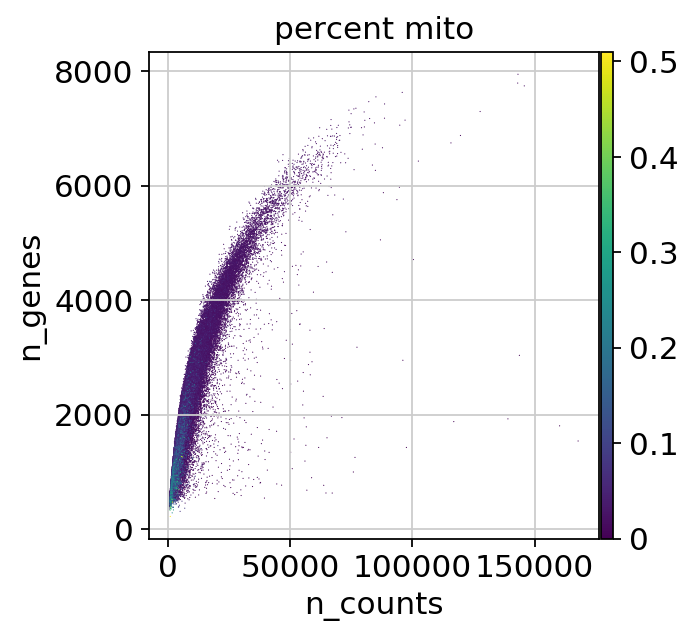

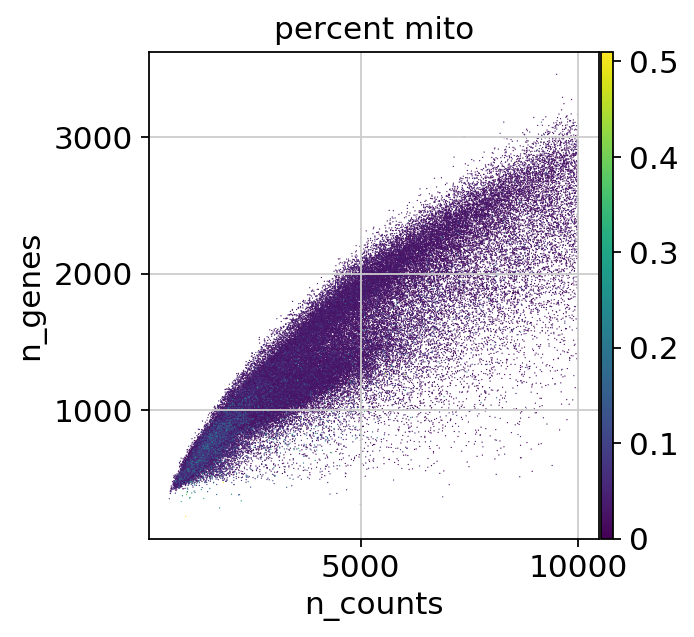

In [83]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


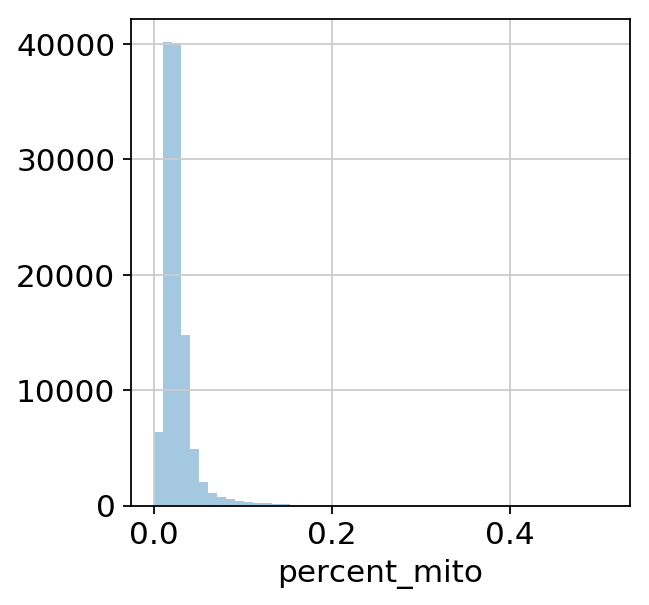

In [84]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [85]:
np.percentile(list(adata.obs['percent_mito']),20)

0.015571030229330063

In [86]:
len(adata[adata.obs['percent_mito'] > 0.2])

153

In [87]:
len(adata[adata.obs['percent_mito'] > 0.2])/len(adata.obs)

0.0013585870694477742

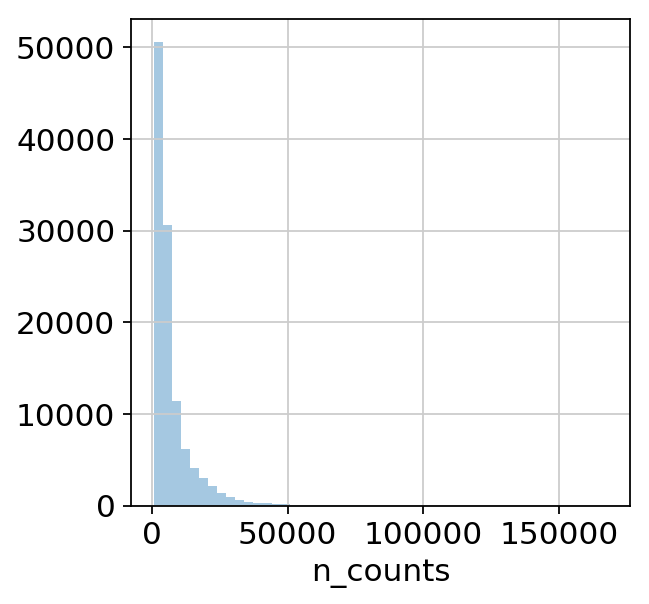

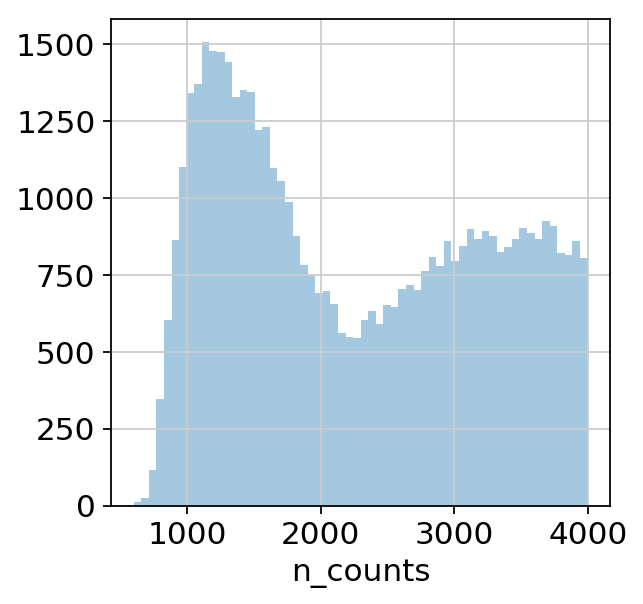

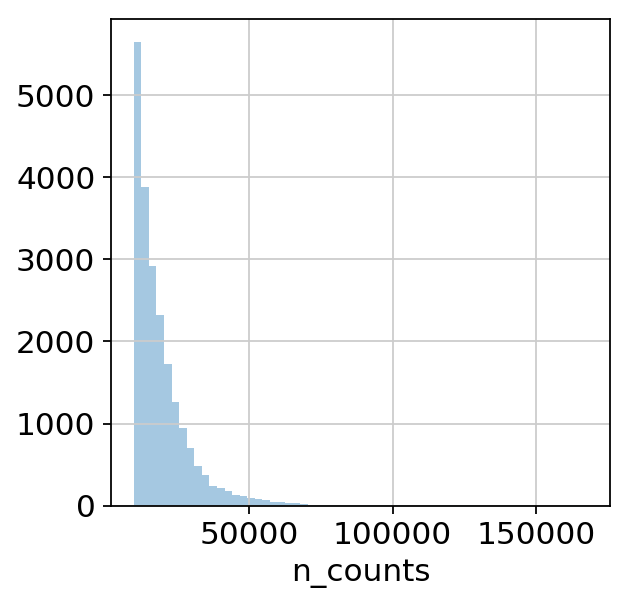

In [88]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


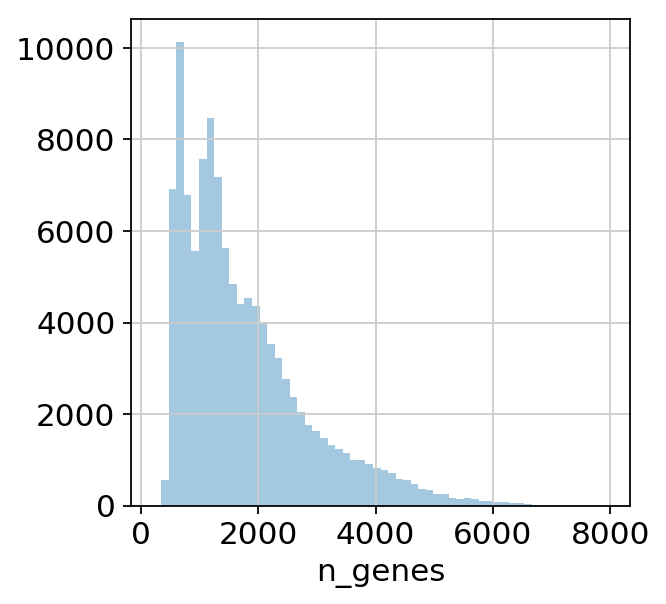

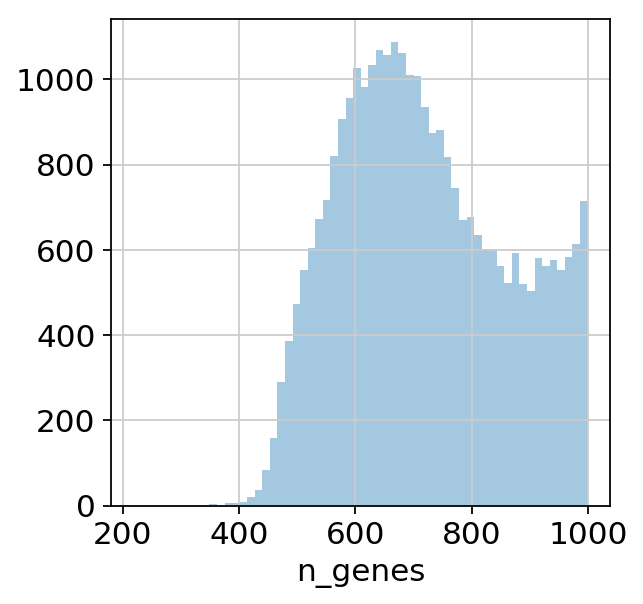

In [89]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up to reread and filter there

In [92]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363'], dtype=object)

In [93]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == '35008_CV005_RV9039258_and_35008_CV005_RV9039282'].X.todense()
np.unique(check)

matrix([[    0.,     0.,     0., ..., 31715., 32580., 35153.]],
       dtype=float32)

This is happening in the cell below:
- read the raw file (output of cellranger)
- call doublets according to bertie doublet caller and adding all the scores
- Filter: 1) cells (< 500 genes); 2) genes (< 3 cells); 
- Add %mt genes
- Add relevant annotation info

In [108]:
%%time

holder = []

# for doublets
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
#os.makedirs('scrublet_scores')

for sample in samples:
    print('sample', sample,
          "from scRNA-seq samples", list(samples).index(sample)+1,
          'out of', len(samples))
    
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    
    
    path_complete = path+'filtered_feature_bc_matrix.h5'
    holder.append(sc.read_10x_h5(path_complete,
                                gex_only=False))
    
    holder[-1].var_names_make_unique()
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Adding donor information
    
    curr_info = sample2activation[sample]
    
    holder[-1].obs['stimulation'] = curr_info
    holder[-1].layers['counts'] = holder[-1].X.copy()
    #print('this was tissue block', block, 'sample:', sample)
    
    # Sample information
    holder[-1].obs['sample'] = sample
    # In cell_id we save barcode+sample index, to be unique in the future
    holder[-1].obs['cell_id'] = [i+'_'+j for i,j in zip(holder[-1].obs.index, holder[-1].obs['sample'])]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    holder[-1].obs['dataset'] = 'GEX+CITE-seq'
    holder[-1].obs['technique'] = '10X'
    
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    
    # for doublet detection we only consider GEX data
    curr_adata_GEX = holder[-1][:, holder[-1].var["feature_types"] == "Gene Expression"].copy()
    
    scores_table = bertie(curr_adata_GEX, sample)
    if list(scores_table.index) == list(curr_adata_GEX.obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta in scorenames:
            holder[-1].obs[meta] = scores_table[meta]
    else:
        print('indices in current bertie table and sample adata are NOT matching')

sample 35008_CV005_RV9039258_and_35008_CV005_RV9039282 from scRNA-seq samples 1 out of 9
reading /lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_35008_CV005_RV9039258_and_35008_CV005_RV9039282_GRCh38-1_2_0/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
filtered out 16440 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/uma

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
filtered out 16099 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 34 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
filtered out 16665 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 15883 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 32 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 36 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 16473 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 17209 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)
filtered out 14429 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 30 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 34 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)
filtered out 13511 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 26 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 35 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 40 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)
filtered out 14110 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 31 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 37 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 

____________________________________________________________________________________________________________

Carrying on to:
- Concatenate

In [109]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()

layers concatenation is not yet available for 'outer' intersection and will be ignored.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


CPU times: user 4min 44s, sys: 1min 13s, total: 5min 58s
Wall time: 5min 57s


Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [110]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [111]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
# this parameter can be tweaked according to how harsh the detection needs to be
# the less it is, the less doublets it will call
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

In [115]:
adata

AnnData object with n_obs × n_vars = 186705 × 21749 
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8'

In [117]:
donor_meta

,donor
cell_id,
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CONTROL4
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID33
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
...,...
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363,CVID23
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363,CVID25


In [10]:
donor_meta = pd.read_csv(save_path + 'meta_cells_for_reanalysis_without_twins_without_BCR_activation_without_souporcell_doublets.csv',
                        index_col=0)

In [12]:
donor_meta

,cell_id,donor
AAACCTGAGAATGTGT-1,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,CVID3
AAACCTGAGACTAAGT-1,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,CONTROL4
AAACCTGAGCCGCCTA-1,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,CVID3
AAACCTGAGCGCCTCA-1,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,CVID33
AAACCTGAGGATGTAT-1,AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_3...,CVID3
...,...,...
TTTGTCATCCCTTGCA-1-1,TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCCGCGTTT-1,TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363,CVID23
TTTGTCATCGGAGGTA-1,TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCGGCTACG-1-1,TTTGTCATCGGCTACG-1_35171_CV005_RV9039363,CVID25


In [13]:
donor_meta.set_index('cell_id', inplace=True)

In [14]:
donor_meta

,donor
cell_id,
AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CONTROL4
AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID33
AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_35008_CV005_RV9039282,CVID3
...,...
TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363,CVID25
TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363,CVID23
TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363,CVID25


In [19]:
# subsetting to only selected cells (after excluding souporcell doublets, twin data and BCR activation)
adata = adata[adata.obs['cell_id'].isin(donor_meta.index)].copy()
adata.obs['donor'] = list(donor_meta.loc[adata.obs['cell_id'], 'donor'])

In [22]:
adata

AnnData object with n_obs × n_vars = 112463 × 21749 
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8'

In [20]:
np.unique(adata.obs['donor'])

array(['CONTROL2', 'CONTROL3', 'CONTROL4', 'CONTROL5', 'CONTROL6',
       'CONTROL7', 'CONTROL8', 'CONTROL9', 'CVID1', 'CVID18', 'CVID23',
       'CVID25', 'CVID29', 'CVID3', 'CVID33', 'CVID34', 'CVID36',
       'CVID37'], dtype=object)

In [21]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

In [23]:
# without BCR activation, without twins data, without souporcell doublets
adata.write(save_path+'adata_raw_filtered_validation_cohort.h5ad')

... storing 'donor' as categorical


In [24]:
np.unique(adata.obs['sample'])

array(['35008_CV005_RV9039258_and_35008_CV005_RV9039282',
       '35008_CV005_RV9039259_and_35008_CV005_RV9039283',
       '35008_CV005_RV9039260_and_35008_CV005_RV9039284',
       '35008_CV005_RV9039261_and_35008_CV005_RV9039285',
       '35008_CV005_RV9039262_and_35008_CV005_RV9039286',
       '35008_CV005_RV9039263_and_35008_CV005_RV9039287',
       '35171_CV005_RV9039361', '35171_CV005_RV9039362',
       '35171_CV005_RV9039363'], dtype=object)

In [25]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == '35008_CV005_RV9039258_and_35008_CV005_RV9039282'].X.todense()
np.unique(check)

matrix([[    0.,     0.,     0., ..., 31715., 32580., 35153.]],
       dtype=float32)

In [7]:
# reading
adata = sc.read(save_path+'adata_raw_filtered_validation_cohort.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 112463 × 21749 
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8'

In [9]:
np.unique(adata.obs['donor'])

array([nan, nan, nan, ..., nan, nan, nan], dtype=object)

In [134]:
adata.obs

,batch,bh_pval,cell_id,dataset,n_counts,n_genes,percent_mito,sample,scrublet_cluster_score,scrublet_score,stimulation,technique,is_doublet,donor
index,,,,,,,,,,,,,,
AAACCTGAGAATGTGT-1,0,0.889727,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,7290.0,2702,0.018107,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.121951,0.228916,unstim,10X,False,NaN
AAACCTGAGACTAAGT-1,0,0.889727,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,12742.0,3009,0.039083,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.101341,0.109890,unstim,10X,False,NaN
AAACCTGAGCCGCCTA-1,0,0.889727,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1274.0,630,0.039246,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.097384,0.045720,unstim,10X,False,NaN
AAACCTGAGCGCCTCA-1,0,0.889727,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1137.0,629,0.028144,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.081753,0.142056,unstim,10X,False,NaN
AAACCTGAGGATGTAT-1,0,0.889727,AAACCTGAGGATGTAT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1045.0,571,0.015311,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.072961,0.044019,unstim,10X,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCCTTGCA-1-1,8,0.871054,TTTGTCATCCCTTGCA-1_35171_CV005_RV9039363,GEX+CITE-seq,10308.0,2240,0.052581,35171_CV005_RV9039363,0.097230,0.584296,CD3,10X,False,NaN
TTTGTCATCCGCGTTT-1,8,0.949569,TTTGTCATCCGCGTTT-1_35171_CV005_RV9039363,GEX+CITE-seq,3022.0,1066,0.014229,35171_CV005_RV9039363,0.076029,0.024129,CD3,10X,False,NaN
TTTGTCATCGGAGGTA-1,8,0.949569,TTTGTCATCGGAGGTA-1_35171_CV005_RV9039363,GEX+CITE-seq,3058.0,1076,0.010137,35171_CV005_RV9039363,0.038408,0.020513,CD3,10X,False,NaN


In [135]:
adata.var['feature_types-0'].value_counts()

Gene Expression     17254
nan                  4303
Antibody Capture      192
Name: feature_types-0, dtype: int64

# Producing a QC table

In [125]:
tables = {}

for sample in samples:
    print(sample)
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    tables[sample] = pd.read_csv(path + 'metrics_summary.csv')

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363


In [126]:
table_merged = pd.DataFrame(columns = list(tables.values())[0].columns,
                           index = samples)

In [127]:
for sample in samples:
    print(sample)
    table_merged.loc[sample,:] = list(tables[sample].loc[0,:])

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363


In [128]:
table_merged.to_csv('./QC_metrics_cellranger_all_samples.csv')

In [129]:
# number of cell called by cellranger
num_of_cells = [int(elem.split(',')[0]+elem.split(',')[1]) for elem in list(table_merged['Estimated Number of Cells'])]

In [130]:
num_of_cells

[17720, 19435, 12415, 19832, 22268, 20522, 21465, 23553, 29947]

In [131]:
num_of_cells_total = np.sum(num_of_cells)

In [132]:
num_of_cells_total

187157